In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering 
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = "Data/customer_data.csv"
df = pd.read_csv(data_path)
df.head()
df.dropna(inplace=True)
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format="%d-%m-%Y")
reference_date = df['Dt_Customer'].max()
df['Customer_Tenure'] = (reference_date - df['Dt_Customer']).dt.days
df['Age'] = reference_date.year - df['Year_Birth']
# Combining Common Columns:
df['Campaigns'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']
df['Mnt'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
df['Purchases'] = df['NumDealsPurchases'] + df[ 'NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] + df['NumWebVisitsMonth']
df['Children'] = df['Kidhome'] + df['Teenhome']
df.drop(['Z_CostContact', 'Z_Revenue', 'Dt_Customer', 'ID','Year_Birth','Dt_Customer','Kidhome','Teenhome',
'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 
'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases','NumStorePurchases', 'NumWebVisitsMonth']
,axis=1,inplace=True)
for col in df.columns:
    if df[col].dtype == object:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

In [3]:
df_scaled = StandardScaler().fit_transform(df)
pd.DataFrame(df_scaled, columns=df.columns).describe()

,Education,Marital_Status,Income,Recency,Complain,Response,Customer_Tenure,Age,Campaigns,Mnt,Purchases,Children
count,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03,2.216000e+03
mean,1.282568e-16,-9.779582e-17,5.210433e-17,-2.404815e-18,1.523050e-17,2.885778e-17,-1.170343e-16,8.196412e-17,-1.282568e-17,1.442889e-17,-1.410825e-16,-2.565136e-17
std,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00,1.000226e+00
min,-2.130065e+00,-3.458120e+00,-2.007250e+00,-1.693488e+00,-9.781206e-02,-4.205300e-01,-1.746741e+00,-2.268209e+00,-4.392649e-01,-9.988568e-01,-2.774123e+00,-1.264803e+00
25%,-3.505273e-01,-6.738665e-01,-6.732620e-01,-8.642385e-01,-9.781206e-02,-4.205300e-01,-8.573649e-01,-6.826092e-01,-4.392649e-01,-8.926794e-01,-8.514548e-01,-1.264803e+00
50%,-3.505273e-01,2.542181e-01,-3.439972e-02,-4.365786e-04,-9.781206e-02,-4.205300e-01,9.777165e-03,-9.844093e-02,-4.392649e-01,-3.493494e-01,-1.647877e-01,7.050118e-02
75%,5.392418e-01,1.182303e+00,6.466600e-01,8.633654e-01,-9.781206e-02,-4.205300e-01,8.670373e-01,8.195377e-01,-4.392649e-01,7.315041e-01,6.592128e-01,7.050118e-02
max,1.429011e+00,3.038472e+00,2.441328e+01,1.727167e+00,1.022369e+01,2.377952e+00,1.707004e+00,6.327410e+00,5.451271e+00,3.181881e+00,3.543215e+00,2.741110e+00


In [4]:
# checking for outliers:
for col in df.columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    print(col, df[df[col].between(q1-1.5*iqr, q3+1.5*iqr)].shape[0])
print('-'*100)


Education 2016
Marital_Status 2216
Income 2208
Recency 2216
Complain 2195
Response 1883
Customer_Tenure 2216
Age 2213
Campaigns 1757
Mnt 2213
Purchases 2213
Children 2166
----------------------------------------------------------------------------------------------------


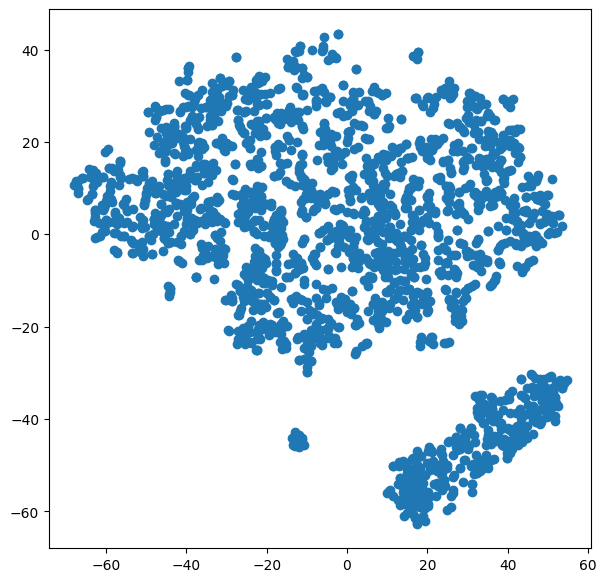

In [5]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(df_scaled)
plt.figure(figsize=(7, 7))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1])
plt.show()

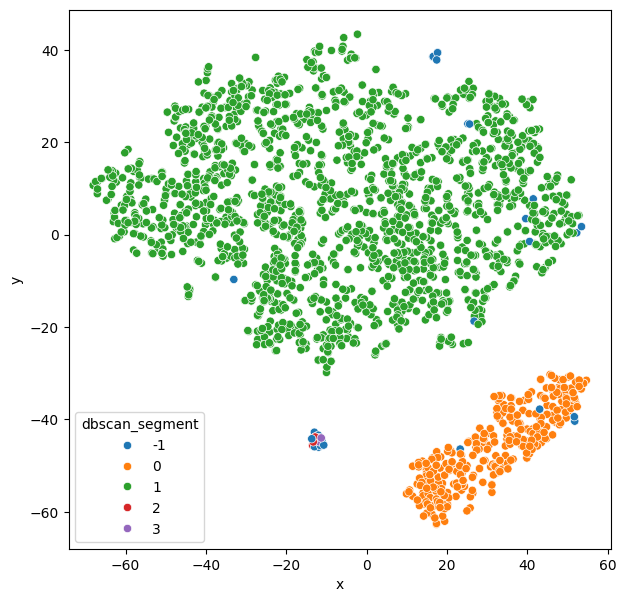

In [8]:
df_tsne = pd.DataFrame({'x': tsne_data[:, 0], 'y': tsne_data[:, 1]})
eps_, samp = 2.75,3
dbscan_model = DBSCAN(eps=eps_, min_samples=samp)
dbscan_labels = dbscan_model.fit_predict(df_scaled)
df_tsne["dbscan_segment"] = dbscan_labels

plt.figure(figsize=(7, 7))
sns.scatterplot(x='x', y='y', hue='dbscan_segment', data=df_tsne, palette='tab10')
plt.show()


In [9]:
df_tsne['dbscan_segment'].value_counts()

dbscan_segment
 1    1851
 0     326
-1      26
 2       8
 3       5
Name: count, dtype: int64